# Test case A: Sequential OED

In [108]:
import numpy as np
from jax import jit, vjp, vmap, pmap
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

In [109]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

def solve_helmholtz_general(sound_speed, src_coord, omega):
    # Ensure src_coord is at least 1D
    src_coord = jnp.atleast_1d(src_coord)
    # print("src_coord:", src_coord, "shape:", src_coord.shape)

    x, y = src_coord[0], src_coord[1]
    src = create_src_field(N, x, y, domain, omega)
    medium = Medium(domain=domain, sound_speed=sound_speed, density=1000., pml_size=10)
    field = helmholtz_solver(medium, omega, src)
    return field.on_grid.squeeze()




In [110]:
def extract_receiver_values_interpolated(field, receiver_coords):
    # Assume receiver_coords is a float array with shape (n_receivers, 2)
    x_floor = jnp.floor(receiver_coords[:, 0]).astype(jnp.int32)
    y_floor = jnp.floor(receiver_coords[:, 1]).astype(jnp.int32)
    x_ceil = jnp.ceil(receiver_coords[:, 0]).astype(jnp.int32)
    y_ceil = jnp.ceil(receiver_coords[:, 1]).astype(jnp.int32)

    # Interpolation weights
    wx = receiver_coords[:, 0] - x_floor
    wy = receiver_coords[:, 1] - y_floor

    # Bilinear interpolation
    top_left = field[x_floor, y_floor]
    top_right = field[x_floor, y_ceil]
    bottom_left = field[x_ceil, y_floor]
    bottom_right = field[x_ceil, y_ceil]

    interpolated_values = (
        (1 - wx)[:, None] * (1 - wy)[:, None] * top_left +
        wx[:, None] * (1 - wy)[:, None] * top_right +
        (1 - wx)[:, None] * wy[:, None] * bottom_left +
        wx[:, None] * wy[:, None] * bottom_right
    )

    # Return real and imaginary parts separately
    return jnp.real(interpolated_values), jnp.imag(interpolated_values)


def compute_jacobian_at_receivers_vjp(sound_speed, src_coords, omega, receiver_coords):
    def field_at_receivers(sound_speed, src_coord, receiver_coords, omega):
        # Ensure receiver_coords has shape (n_receivers, 2)
        assert receiver_coords.ndim == 2 and receiver_coords.shape[1] == 2, \
            f"Invalid receiver_coords shape: {receiver_coords.shape}"
        
        field = solve_helmholtz_general(sound_speed, src_coord, omega)
        rec_real, rec_imag = extract_receiver_values_interpolated(field, receiver_coords)
        return rec_real, rec_imag
    
    jacobians_real = []
    jacobians_imag = []
    
    for src_coord in src_coords:
        # Compute VJP for the given source
        (y_real, y_imag), vjp_fn = vjp(lambda s: field_at_receivers(s, src_coord, receiver_coords, omega), sound_speed)
        
        # Calculate VJP for both real and imaginary parts
        jacobian_real = vjp_fn((jnp.ones_like(y_real), jnp.zeros_like(y_imag)))[0]
        jacobian_imag = vjp_fn((jnp.zeros_like(y_real), jnp.ones_like(y_imag)))[0]
        
        jacobians_real.append(jacobian_real)
        jacobians_imag.append(jacobian_imag)
    
    # Stack the Jacobians for each source
    return jnp.array(jacobians_real), jnp.array(jacobians_imag)

In [111]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution

# Defining the domain
domain = Domain(N, dx)

In [112]:
# def compute_and_store_jacobians(sound_speed, frequencies, src_coords_list, receiver_coords_list):
#     n_sources = len(src_coords_list)
#     n_receivers = len(receiver_coords_list)
#     n_frequencies = len(frequencies)

#     # Preallocate storage for Jacobians
#     jacobian_shape = (n_sources, n_receivers, n_frequencies, 70, 140)  # Assuming the Jacobian is 70x140
#     jacobians = jnp.zeros(jacobian_shape)

#     for f_idx, f in enumerate(frequencies):
#         omega = 2 * jnp.pi * f
        

#         for s_idx, src_coords in enumerate(src_coords_list):
#         #    print progression in number of frequency and source with respect to total number of frequencies and sources
#             print("Freq:",f_idx,"/",n_frequencies,"  Source:", s_idx,"/", n_sources, "    Total progression:", f_idx*n_sources+s_idx,"/",n_frequencies*n_sources)

#             for r_idx, receiver_coords in enumerate(receiver_coords_list):
#                 # Compute Jacobian for the specific triplet
#                 jacobian_real, jacobian_imag = compute_jacobian_at_receivers_vjp(
#                     sound_speed, src_coords, omega, receiver_coords[None, :]
#                 )

#                 # Combine real and imaginary parts into a single 2D matrix
#                 jacobian_2d = jnp.hstack((
#                     jacobian_real.reshape(-1, jacobian_real.shape[-1]),
#                     jacobian_imag.reshape(-1, jacobian_imag.shape[-1])
#                 ))

#                 # Store in the preallocated array
#                 jacobians = jacobians.at[s_idx, r_idx, f_idx, :, :].set(jacobian_2d)

#     return jacobians



In [113]:
# frequencies = [40, 50, 80, 100, 150, 200]  # List of frequencies

# src_coords_list = [
#     jnp.array([[60.1, 16.1]]).astype(jnp.float32),
#     jnp.array([[60.1, 24.1]]).astype(jnp.float32),
#     jnp.array([[60.1, 32.1]]).astype(jnp.float32),
#     jnp.array([[60.1, 40.1]]).astype(jnp.float32),
#     jnp.array([[60.1, 48.1]]).astype(jnp.float32),
# ]  

# receiver_coords_list = jnp.array([
#     [8.1, 0.125 * N[1] + 0.1],
#     [8.1, 0.25 * N[1] + 0.1],
#     [8.1, 0.5 * N[1] + 0.1],
#     [8.1, 0.75 * N[1] + 0.1],
#     [8.1, 0.9 * N[1] + 0.1],
# ]).astype(jnp.float32)

# sound_speed = jnp.ones(N) * 1500  # Example sound speed model

In [114]:
# jacobians_homo = compute_and_store_jacobians(
#     sound_speed, frequencies, src_coords_list, receiver_coords_list
# )
# print("Jacobian array shape:", jacobians_homo.shape)

In [115]:
# jacobians_curvel = compute_and_store_jacobians(
#     curvel_single_model, frequencies, src_coords_list, receiver_coords_list
# )
# print("Jacobian array shape:", jacobians_curvel.shape)

### Load the curvel model

(500, 1, 70, 70)


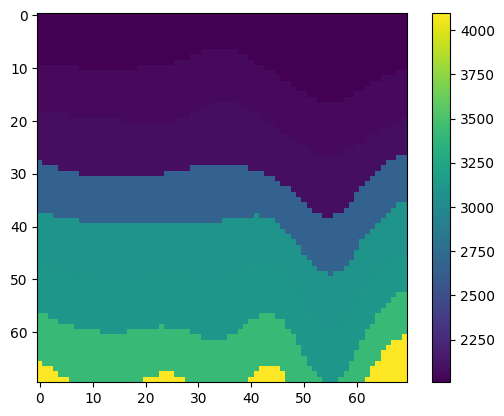

<class 'jaxlib.xla_extension.ArrayImpl'>


In [116]:
model = jnp.load('model1.npy')
print(model.shape)

curvel_single_model = model[7,0,:,:]
plt.imshow(curvel_single_model)
plt.colorbar()
plt.show()
print(type(curvel_single_model))

In [117]:
# Inputs preparation 

frequencies = jnp.array([40, 70, 100, 150, 200])  # List of frequencies
# frequencies = jnp.array([50,75])

# src_coords_list = jnp.array([
#     [60.1, 16.1],
#     [60.1, 24.1],
#     [60.1, 32.1],
#     [60.1, 40.1],
#     [60.1, 48.1],
# ]  ).astype(jnp.float32)

# receiver_coords_list = jnp.array([
#     [8.1, 0.125 * N[1] + 0.1],
#     [8.1, 0.25 * N[1] + 0.1],
#     [8.1, 0.5 * N[1] + 0.1],
#     [8.1, 0.75 * N[1] + 0.1],
#     [8.1, 0.9 * N[1] + 0.1],
# ]).astype(jnp.float32)

def generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=20, num_receivers=10):
    """
    Generate a 2D grid of positions for sources and receivers with more sources than receivers,
    arranged in a staggered grid. The offset between a source and a receiver is half the source spacing.

    Parameters:
    - N: Tuple[int, int], dimensions of the 2D grid (Nx, Ny).
    - num_sources: int, number of source positions along each axis.
    - num_receivers: int, number of receiver positions along each axis.

    Returns:
    - src_coords: jnp.ndarray, source positions as a 2D array.
    - recv_coords: jnp.ndarray, receiver positions as a 2D array.
    """
    Nx, Ny = N

    # Generate evenly spaced indices for sources
    src_x = jnp.linspace(5, Nx - 5, num_sources, dtype=jnp.float32)
    src_y = jnp.linspace(5, Ny - 5, num_sources, dtype=jnp.float32)

    # Compute receiver positions with fewer points
    recv_x = jnp.linspace(5 + (src_x[1] - src_x[0]) / 2 + 0.1, Nx - 5 - (src_x[1] - src_x[0]) / 2 + 0.1, num_receivers, dtype=jnp.float32)
    recv_y = jnp.linspace(5 + (src_y[1] - src_y[0]) / 2 + 0.1, Ny - 5 - (src_y[1] - src_y[0]) / 2 + 0.1, num_receivers, dtype=jnp.float32)

    # Create 2D grid coordinates for sources and receivers
    src_coords = jnp.array([[x + 0.1, y + 0.1] for x in src_x for y in src_y], dtype=jnp.float32)
    recv_coords = jnp.array([[x + 0.1, y + 0.1] for x in recv_x for y in recv_y], dtype=jnp.float32)

    return src_coords, recv_coords
    

src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


print("src_coords_list shape:", src_coords_list.shape)
print(src_coords_list)
print(type(src_coords_list))

# sound_speed = jnp.ones((70, 70)) * 1500  # Shape: (grid_x, grid_y)

sound_speed = curvel_single_model

# Get the number of available devices
num_devices = len(jax.devices())  # 12
print(f"Available devices: {num_devices}")

src_coords_list shape: (25, 2)
[[ 5.1  5.1]
 [ 5.1 20.1]
 [ 5.1 35.1]
 [ 5.1 50.1]
 [ 5.1 65.1]
 [20.1  5.1]
 [20.1 20.1]
 [20.1 35.1]
 [20.1 50.1]
 [20.1 65.1]
 [35.1  5.1]
 [35.1 20.1]
 [35.1 35.1]
 [35.1 50.1]
 [35.1 65.1]
 [50.1  5.1]
 [50.1 20.1]
 [50.1 35.1]
 [50.1 50.1]
 [50.1 65.1]
 [65.1  5.1]
 [65.1 20.1]
 [65.1 35.1]
 [65.1 50.1]
 [65.1 65.1]]
<class 'jaxlib.xla_extension.ArrayImpl'>
Available devices: 12


In [118]:
# batching the inputs


# Debugging Input Shapes
print("frequencies shape:", frequencies.shape)
print("src_coords_list shape:", src_coords_list.shape)
print("receiver_coords_list shape:", receiver_coords_list.shape)

n_f = frequencies.shape[0]
n_s = src_coords_list.shape[0]
n_r = receiver_coords_list.shape[0]

frequencies_tile = jnp.broadcast_to(frequencies[:, None, None], (n_f, n_s, n_r))
src_coords_tile = jnp.broadcast_to(src_coords_list[None, :, None, :], (n_f, n_s, n_r, 2))
receiver_coords_tile = jnp.broadcast_to(receiver_coords_list[None, None, :, :], (n_f, n_s, n_r, 2))

print("frequencies_tile shape:", frequencies_tile.shape)
print("src_coords_tile shape:", src_coords_tile.shape)
print("receiver_coords_tile shape:", receiver_coords_tile.shape)

print(src_coords_tile[0,0,0,:],src_coords_tile[0,1,0,:])
print(receiver_coords_tile[0,0,0,:],receiver_coords_tile[0,0,1,:])
print(jnp.unique(src_coords_tile.reshape(-1, 2), axis=0))

# Flatten into a single batch for parallel processing
frequencies_flat = frequencies_tile.reshape(-1)
src_coords_flat = src_coords_tile.reshape(-1, 2)
receiver_coords_flat = receiver_coords_tile.reshape(-1, 2)

print("frequencies_flat shape:", frequencies_flat.shape)
print("src_coords_flat shape:", src_coords_flat.shape)
print("receiver_coords_flat shape:", receiver_coords_flat.shape)

# Check unique source coordinates to ensure differences per source
print("Unique src_coords_flat:", jnp.unique(src_coords_flat, axis=0))

# Pad to match the number of devices
def pad_to_multiple(arr, num_devices):
    pad_size = (-len(arr)) % num_devices
    return jnp.pad(arr, ((0, pad_size),) + ((0, 0),) * (arr.ndim - 1), constant_values=10.1)

frequencies_flat = pad_to_multiple(frequencies_flat, num_devices)
src_coords_flat = pad_to_multiple(src_coords_flat, num_devices)
receiver_coords_flat = pad_to_multiple(receiver_coords_flat, num_devices)

print("Padded frequencies_flat shape:", frequencies_flat.shape)
print("Padded src_coords_flat shape:", src_coords_flat.shape)
print("Padded receiver_coords_flat shape:", receiver_coords_flat.shape)

# Chunk the inputs into batches of `num_devices`
num_batches = len(frequencies_flat) // num_devices
frequencies_batched = frequencies_flat.reshape(num_batches, num_devices)
src_coords_batched = src_coords_flat.reshape(num_batches, num_devices, 2)
receiver_coords_batched = receiver_coords_flat.reshape(num_batches, num_devices, 2)


frequencies shape: (5,)
src_coords_list shape: (25, 2)
receiver_coords_list shape: (25, 2)
frequencies_tile shape: (5, 25, 25)
src_coords_tile shape: (5, 25, 25, 2)
receiver_coords_tile shape: (5, 25, 25, 2)
[5.1 5.1] [ 5.1 20.1]
[12.700001 12.700001] [12.700001 23.95    ]
[[ 5.1  5.1]
 [ 5.1 20.1]
 [ 5.1 35.1]
 [ 5.1 50.1]
 [ 5.1 65.1]
 [20.1  5.1]
 [20.1 20.1]
 [20.1 35.1]
 [20.1 50.1]
 [20.1 65.1]
 [35.1  5.1]
 [35.1 20.1]
 [35.1 35.1]
 [35.1 50.1]
 [35.1 65.1]
 [50.1  5.1]
 [50.1 20.1]
 [50.1 35.1]
 [50.1 50.1]
 [50.1 65.1]
 [65.1  5.1]
 [65.1 20.1]
 [65.1 35.1]
 [65.1 50.1]
 [65.1 65.1]]
frequencies_flat shape: (3125,)
src_coords_flat shape: (3125, 2)
receiver_coords_flat shape: (3125, 2)
Unique src_coords_flat: [[ 5.1  5.1]
 [ 5.1 20.1]
 [ 5.1 35.1]
 [ 5.1 50.1]
 [ 5.1 65.1]
 [20.1  5.1]
 [20.1 20.1]
 [20.1 35.1]
 [20.1 50.1]
 [20.1 65.1]
 [35.1  5.1]
 [35.1 20.1]
 [35.1 35.1]
 [35.1 50.1]
 [35.1 65.1]
 [50.1  5.1]
 [50.1 20.1]
 [50.1 35.1]
 [50.1 50.1]
 [50.1 65.1]
 [65.1  5.1]


In [119]:
# Define the computation
def compute_jacobian_single(f, src_coord, receiver_coord, sound_speed):
    omega = 2 * jnp.pi * f
    jacobian_real, jacobian_imag = compute_jacobian_at_receivers_vjp(
        sound_speed, src_coord[None,:], omega, receiver_coord[None, :]
    )
    jacobian_2d = jnp.hstack((
        jacobian_real.reshape(-1, jacobian_real.shape[-1]),
        jacobian_imag.reshape(-1, jacobian_imag.shape[-1])
    ))
    return jacobian_2d

# # Parallelize over devices
compute_jacobian_parallel = pmap(
    lambda f, src, rec: compute_jacobian_single(f, src, rec, sound_speed),
    in_axes=(0, 0, 0)  # Map over all batched inputs
)

# Execute the computation batch by batch
jacobians_batches = []
for i in range(num_batches):
    print("Batch:", i, "/", num_batches)
    # print freq, src, receiver coordinates for each batch
    # print("frequencies_batched:", frequencies_batched[i])
    # print("src_coords_batched:", src_coords_batched[i])
    # print("receiver_coords_batched:", receiver_coords_batched[i])
          
    jacobians_batch = compute_jacobian_parallel(
        frequencies_batched[i], src_coords_batched[i], receiver_coords_batched[i]
    )
    jacobians_batches.append(jacobians_batch)

# Combine all batches
jacobians = jnp.concatenate(jacobians_batches, axis=0)

# Reshape back to original dimensions
jacobians = jacobians[:frequencies_tile.size].reshape(
    frequencies_tile.shape[0], frequencies_tile.shape[1], frequencies_tile.shape[2], -1
)


Batch: 0 / 261
Batch: 1 / 261
Batch: 2 / 261
Batch: 3 / 261
Batch: 4 / 261
Batch: 5 / 261
Batch: 6 / 261
Batch: 7 / 261
Batch: 8 / 261
Batch: 9 / 261
Batch: 10 / 261
Batch: 11 / 261
Batch: 12 / 261
Batch: 13 / 261
Batch: 14 / 261
Batch: 15 / 261
Batch: 16 / 261
Batch: 17 / 261
Batch: 18 / 261
Batch: 19 / 261
Batch: 20 / 261
Batch: 21 / 261
Batch: 22 / 261
Batch: 23 / 261
Batch: 24 / 261
Batch: 25 / 261
Batch: 26 / 261
Batch: 27 / 261
Batch: 28 / 261
Batch: 29 / 261
Batch: 30 / 261
Batch: 31 / 261
Batch: 32 / 261
Batch: 33 / 261
Batch: 34 / 261


KeyboardInterrupt: 

In [97]:
print(jacobians.shape)

(5, 25, 25, 9800)


In [98]:
# save the jacobina forr curvel
# jnp.save("curvel_jac_5_5_5.npy",jacobians)


In [89]:
# save the jacobina forr curvel
# jnp.save("curvel_jac.npy",jacobians_curvel)

# load the jacobians
# jacobians_curvel = jnp.load("curvel_jac.npy")

## Plots the Jacobians

In [87]:
def plot_specific_jacobian(jacobians, frequencies, src_coords, rec_coords, 
                           source_idx=None, receiver_idx=None, frequency_idx=None, save_path=None):
    """
    Plot the real and imaginary parts of a specific Jacobian from a structured array.

    Parameters:
        jacobians (array): Array of shape (n_sources, n_receivers, n_frequencies, rows, cols).
        frequencies (list): List of frequencies corresponding to the third dimension of `jacobians`.
        src_coords (list): List of source coordinates.
        rec_coords (array): Array of receiver coordinates.
        source_idx (int, optional): Index of the source to plot.
        receiver_idx (int, optional): Index of the receiver to plot.
        frequency_idx (int, optional): Index of the frequency to plot.
        save_path (str, optional): Path to save the plots. If None, displays them instead.
    """
    if source_idx is None or receiver_idx is None or frequency_idx is None:
        raise ValueError("You must specify source_idx, receiver_idx, and frequency_idx.")

    # Extract real and imaginary parts
    real_part = jacobians[source_idx, receiver_idx, frequency_idx, :].reshape(70,140)[:,:70]
    imaginary_part = jacobians[source_idx, receiver_idx, frequency_idx, :].reshape(70,140)[:,70:]

    # Plot real part
    plt.figure(figsize=(10, 8))
    plt.imshow(real_part, aspect='auto', cmap='viridis')
    plt.colorbar(label="Magnitude")
    title_real = (
        f"Jacobian Real Part\n"
        f"Frequency: {frequencies[frequency_idx]} Hz, "
        f"Source: {src_coords[source_idx][0]}, "
        f"Receiver: {rec_coords[receiver_idx]}"
    )
    plt.title(title_real)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()

    # Overlay source and receiver markers
    if src_coords is not None and rec_coords is not None:
        plt.scatter(src_coords[source_idx][1], src_coords[source_idx][0], marker='*', c='red', s=100)
        plt.scatter(rec_coords[receiver_idx, 1], rec_coords[receiver_idx, 0], marker='^', c='blue', s=100)

    # Save or show real part
    if save_path:
        filename_real = f"{save_path}/jacobian_real_f{frequency_idx}_s{source_idx}_r{receiver_idx}.png"
        plt.savefig(filename_real, dpi=300)
    else:
        plt.show()

    # Plot imaginary part
    plt.figure(figsize=(10, 8))
    plt.imshow(imaginary_part, aspect='auto', cmap='viridis')
    plt.colorbar(label="Magnitude")
    title_imag = (
        f"Jacobian Imaginary Part\n"
        f"Frequency: {frequencies[frequency_idx]} Hz, "
        f"Source: {src_coords[source_idx][0]}, "
        f"Receiver: {rec_coords[receiver_idx]}"
    )
    plt.title(title_imag)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()

    # Overlay source and receiver markers
    if src_coords is not None and rec_coords is not None:
        plt.scatter(src_coords[source_idx][1], src_coords[source_idx][0], marker='*', c='red', s=100)
        plt.scatter(rec_coords[receiver_idx, 1], rec_coords[receiver_idx, 0], marker='^', c='blue', s=100)

    # Save or show imaginary part
    if save_path:
        filename_imag = f"{save_path}/jacobian_imag_f{frequency_idx}_s{source_idx}_r{receiver_idx}.png"
        plt.savefig(filename_imag, dpi=300)
    else:
        plt.show()

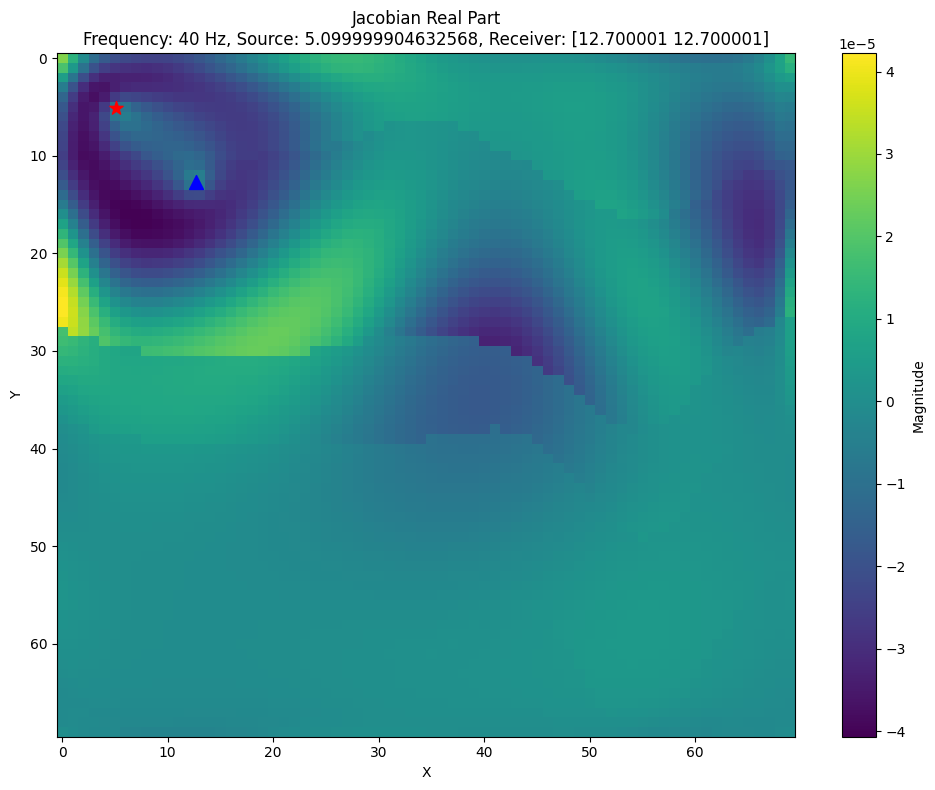

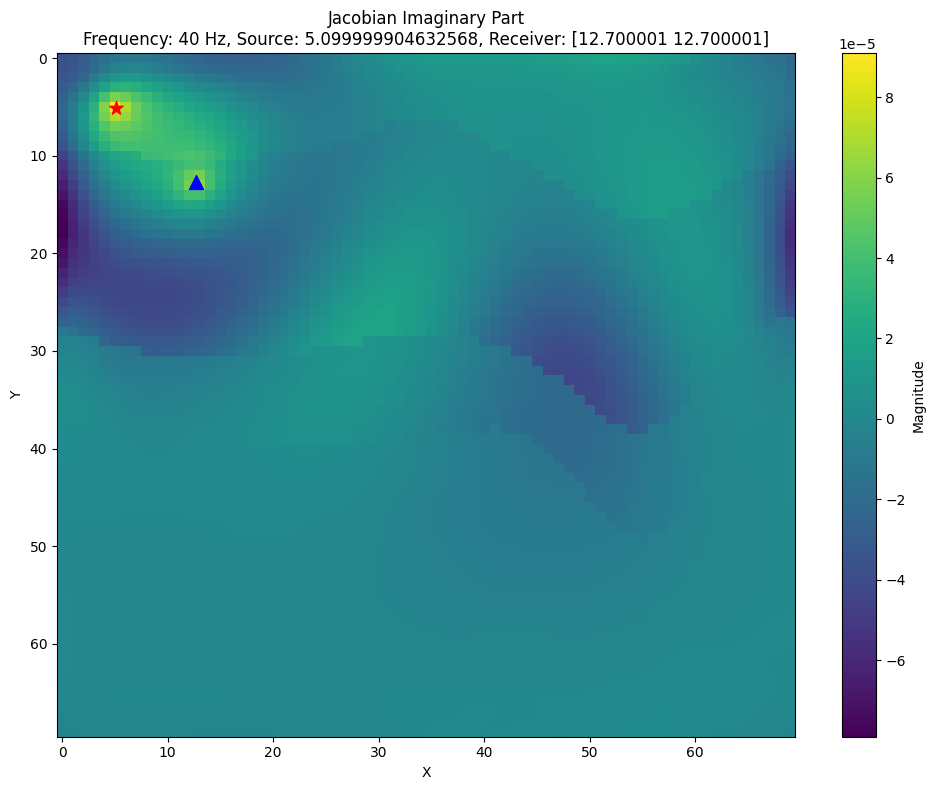

In [99]:
plot_specific_jacobian(jacobians,frequencies, src_coords_list, receiver_coords_list, source_idx=0, receiver_idx=0, frequency_idx=0, save_path=None)

## Sequential OED in JAX with Marmousi jacobian from MODJO

### Checking that the jacobians generated with for the curvel model is in the same structure has the one imported from MODJO

In [100]:
loaded_data = jnp.load('arrays_complete_1GB.npz')

# # Access arrays by index
loaded_arrays = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data))]

# vstack teh arrays
J_c = (jnp.vstack(loaded_arrays))
print(J_c.shape)

(2000, 32768)


In [101]:
print(jacobians.shape[0])
# v stack dimensions 2 and 3
# jacobians_stack = jnp.vstack(jacobians[i])
jac_temp = []
print(jacobians[0].shape)
for i in range(jacobians.shape[0]):
    jac_temp.append(jnp.vstack(jacobians[i]))


jacobians_stack = jnp.vstack(jac_temp)

print(jacobians_stack.shape)

5
(25, 25, 9800)
(3125, 9800)


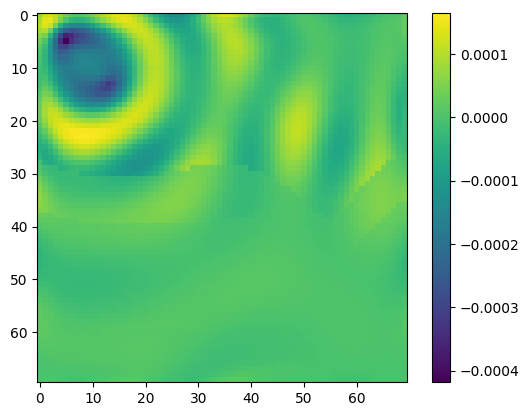

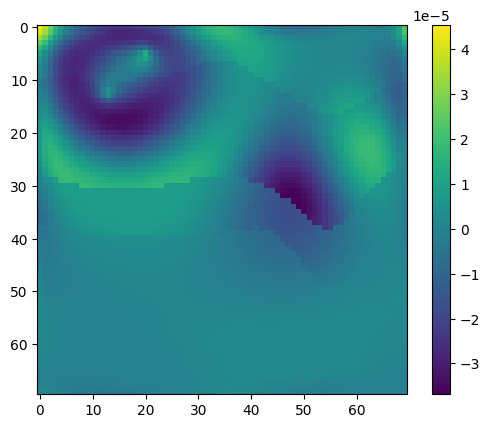

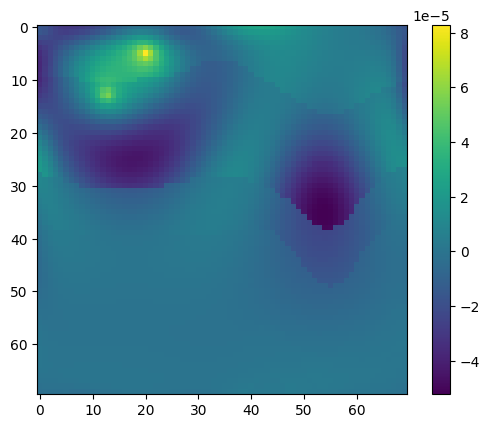

In [102]:
# jacobians
plt.imshow(jacobians[1,0,0,:].reshape(70,140)[:,:70])
plt.colorbar()
plt.show()

# real jacobians_stack
plt.imshow(jacobians_stack[25,:].reshape(70,140)[:,:70])
plt.colorbar()
plt.show()

# imaginary jacobians_stack
plt.imshow(jacobians_stack[25,:].reshape(70,140)[:,70:])
plt.colorbar()
plt.show()



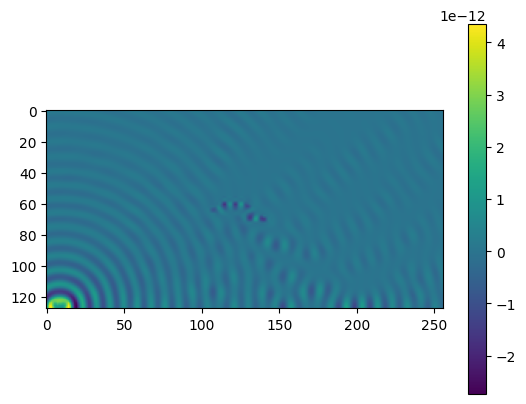

In [103]:
# loaded_arrays
plt.imshow(np.real(J_c[1600,:].reshape(256,128)).T)
plt.colorbar()
plt.show()

(3125, 70, 70)
(3125, 4900)


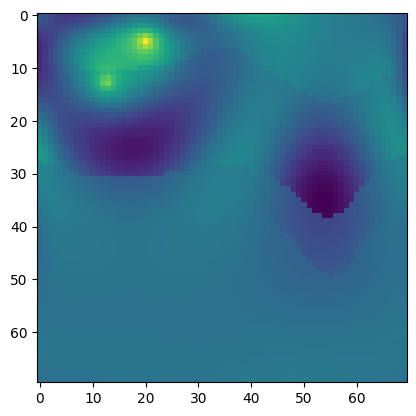

In [104]:
complex_stack = []
for row in jacobians_stack:
    real_part = row.reshape(70,140)[:,:70]
    imaginary_part = row.reshape(70,140)[:,70:]
    complex_stack.append(real_part + 1j * imaginary_part)

# Convert to NumPy array if needed
complex_stack = jnp.array(complex_stack)

print(complex_stack.shape)

# Flatten all rows into num_rows x 4900 matrix
num_rows = jacobians_stack.shape[0]
complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

for i, complex_matrix in enumerate(complex_stack):
    complex_reshaped[i, :] = complex_matrix.flatten()

# Check the shape
print(complex_reshaped.shape)  # Should be (num_rows, 4900)

J_c = complex_reshaped

plt.imshow(np.imag(J_c[25,:].reshape(70,70)))

Iteration: 0, Sources Selected: 0j
Iteration: 1, Sources Selected: (25+0j)
Iteration: 2, Sources Selected: (50+0j)
Iteration: 3, Sources Selected: (75+0j)
Iteration: 4, Sources Selected: (100+0j)
Iteration: 5, Sources Selected: (125+0j)
Iteration: 6, Sources Selected: (150+0j)
Iteration: 7, Sources Selected: (175+0j)
Iteration: 8, Sources Selected: (200+0j)
Iteration: 9, Sources Selected: (225+0j)
Selected rows (indices): [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24 1300 1301 1302
 1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316
 1317 1318 1319 1320 1321 1322 1323 1324 1350 1351 1352 1353 1354 1355
 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369
 1370 1371 1372 1373 1374 1875 1876 1877 1878 1879 1880 1881 1882 1883
 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897
 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911
 1912 

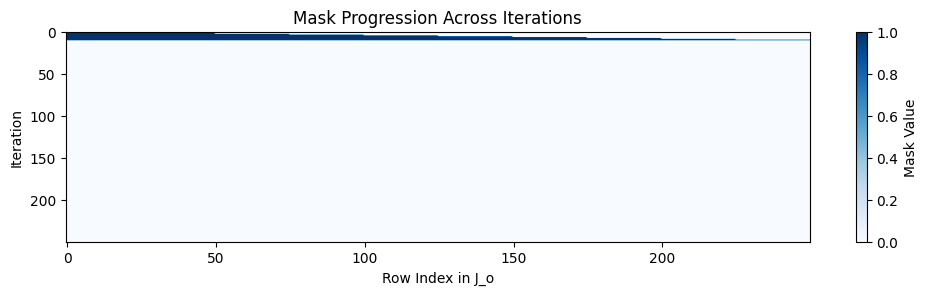

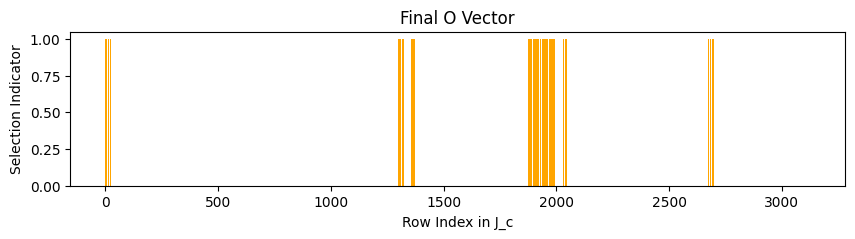

0 0
75 1
52 2
76 3
77 4
78 5
107 6
81 7
79 8
54 9
Ordered list [0, 75, 52, 76, 77, 78, 107, 81, 79, 54]


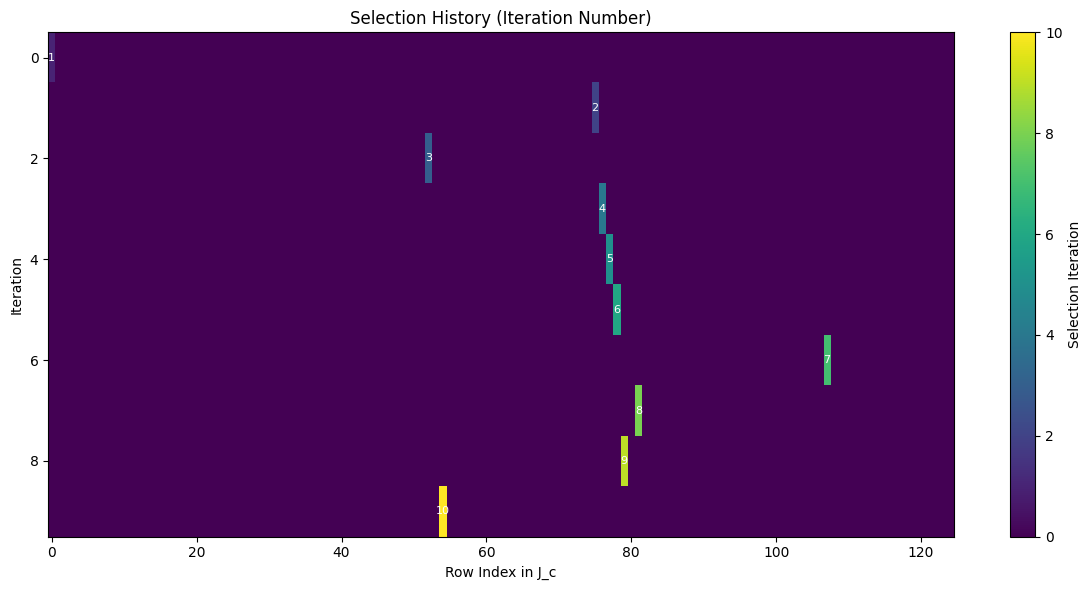

In [107]:
# loaded_data = jnp.load('arrays_complete_1GB.npz')

# # # Access arrays by index
# loaded_arrays = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data))]

# vstack teh arrays
# J_c = (jnp.vstack(loaded_arrays))
# print(J_c.shape)


# Run the algorithm with logging
num_rows = 10
threshold = 10e-10
J_o_final, O_final, mask_history, criterion_log = iterative_selection_no_reselection(J_c, num_rows, n_freq=5, n_receivers=5,selection_mode="block", threshold=threshold)
# J_o_final, O_final, mask_history, criterion_log, augmented_J_o_history = iterative_selection_with_augmented_tracking(J_c, num_rows, threshold)

# Extract the selected row indices
selected_rows = jnp.where(O_final.flatten() == 1)[0]

# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape, "augmented_J_o_history shape", augmented_J_o_history.shape)  
# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape)

# Verify the results
# print("Expected significant rows (indices):", jnp.sort(expected_rows))
print("Selected rows (indices):", selected_rows)

# Check if all expected rows are in the selected rows
# all_expected_selected = jnp.all(jnp.isin(expected_rows, selected_rows))
# print("Are all expected rows among the selected rows?", all_expected_selected)


# Plot the mask history
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(jnp.real(mask_history), aspect='auto', cmap='Blues')
plt.colorbar(label="Mask Value")
plt.xlabel("Row Index in J_o")
plt.ylabel("Iteration")
plt.title("Mask Progression Across Iterations")

# Plot O_final
plt.figure(figsize=(10, 2))
plt.bar(jnp.arange(len(O_final)), jnp.real(O_final.flatten()), color='orange')
plt.xlabel("Row Index in J_c")
plt.ylabel("Selection Indicator")
plt.title("Final O Vector")
plt.show()

# # Plot the criterion values
# plt.subplot(2, 1, 2)
# plt.imshow(criterion_log, aspect='auto', cmap='viridis')
# plt.colorbar(label="Criterion Improvement")
# plt.xlabel("Row Index in J_c")
# plt.ylabel("Iteration")
# plt.title("Criterion Improvement Across Iterations")
# plt.tight_layout()
# plt.show()

# Plot the progression of active_J_o
# plt.figure(figsize=(12, 6))
# for i in range(active_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(active_J_o_history[i], aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")

# plt.tight_layout()
# plt.show()

# Plot the progression of augmented_J_o
# plt.figure(figsize=(12, 12))
# for i in range(augmented_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(jnp.real(augmented_J_o_history[i]), aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     # plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")
# plt.suptitle("Progression of Augmented J_o Across Iterations")
# plt.tight_layout()
# plt.show()


# Create a matrix to record the selection history
selection_history = jnp.zeros_like(criterion_log, dtype=jnp.complex64)

# Populate the selection history matrix with iteration numbers
selected_rows = []
for iteration in range(criterion_log.shape[0]):
    best_row_idx = jnp.argmax(jnp.real(criterion_log[iteration]))  # Get the selected row for this iteration
    selected_rows.append(best_row_idx)
    selection_history = selection_history.at[iteration, best_row_idx].set(iteration + 1)

# Plot the selection history heatmap
plt.figure(figsize=(12, 6))

# Heatmap of selection history
plt.imshow(jnp.real(selection_history), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Selection Iteration")
plt.xlabel("Row Index in J_c")
plt.ylabel("Iteration")
plt.title("Selection History (Iteration Number)")

# Annotate the heatmap with iteration numbers
ordered_list = []
for iteration, row_idx in enumerate(selected_rows):
    plt.text(row_idx, iteration, str(iteration + 1), color="white", ha="center", va="center", fontsize=8)
    print(row_idx, iteration)
    ordered_list.append(row_idx.item())
print("Ordered list", ordered_list)
plt.tight_layout()
plt.show()